<a href="https://colab.research.google.com/github/Ashrafalaghbari/regression-problems-prediction/blob/main/FBHP_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from math import inf
import pickle

In [611]:
df = pd.read_csv("bottomhole_pressure.txt", sep = " ")
# Remove irrelevant vairables ->
df = df.drop(['S.N', 'wh'], axis=1)
# Rename the variables
df  = df.rename(columns={'MBHP': "FBHP", 'QO': "Oil_rate", 'Qg': "Gas_rate", 'QW': "Water_rate", 'TBG': "Tubing_ID",
                   'API': "Oil_gravity", 'P': "Pwh"})

# EDA 

In [259]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FBHP         206 non-null    int64  
 1   Oil_rate     206 non-null    int64  
 2   Gas_rate     206 non-null    float64
 3   Water_rate   206 non-null    int64  
 4   Tubing_ID    206 non-null    float64
 5   DEPTH        206 non-null    int64  
 6   Oil_gravity  206 non-null    float64
 7   STM          206 non-null    int64  
 8   BTM          206 non-null    int64  
 9   Pwh          206 non-null    int64  
dtypes: float64(3), int64(7)
memory usage: 16.2 KB


In [260]:
df

,FBHP,Oil_rate,Gas_rate,Water_rate,Tubing_ID,DEPTH,Oil_gravity,STM,BTM,Pwh
0,2804,4600,2693.37,11000,4.000,6621,32.6,90,212,175
1,2368,700,411.69,1300,2.441,6271,32.6,90,212,230
2,2343,8616,4230.46,2500,3.813,6294,36.5,156,208,285
3,2161,2983,1023.09,905,3.958,6345,32.8,90,180,220
4,2289,3792,1749.74,3796,4.000,6340,32.6,90,212,210
...,...,...,...,...,...,...,...,...,...,...
201,2483,16437,8136.32,0,3.958,6427,36.5,158,209,280
202,2444,11521,8087.74,1683,3.958,6369,36.5,157,209,400
203,2563,3600,2301.92,1750,3.958,6260,32.6,90,212,640
204,2822,2924,1431.85,7659,3.958,6933,32.6,90,212,225


In [261]:
df.isnull().sum()

FBHP           0
Oil_rate       0
Gas_rate       0
Water_rate     0
Tubing_ID      0
DEPTH          0
Oil_gravity    0
STM            0
BTM            0
Pwh            0
dtype: int64

In [84]:
df.describe()

,FBHP,Oil_rate,Gas_rate,Water_rate,Tubing_ID,DEPTH,Oil_gravity,STM,BTM,Pwh
count,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000,206.000000
mean,2489.033981,6321.514563,3416.071068,2700.009709,3.833660,6359.868932,33.772330,117.733010,203.640777,321.077670
std,302.165572,4835.159680,3068.439643,2793.081243,0.387319,566.278874,2.317918,30.793436,16.957251,153.563251
min,1227.000000,280.000000,33.600000,0.000000,1.995000,4550.000000,30.000000,76.000000,157.000000,80.000000
25%,2288.250000,2543.750000,1051.602500,3.250000,3.813000,6299.750000,32.600000,90.000000,208.000000,210.000000
50%,2500.000000,4761.500000,2454.525000,1834.500000,3.958000,6509.500000,32.600000,90.000000,212.000000,280.000000
75%,2700.500000,9576.000000,4918.515000,5033.500000,3.958000,6712.750000,36.500000,155.000000,212.000000,390.000000
max,3217.000000,19618.000000,13562.200000,11000.000000,4.000000,7100.000000,37.000000,160.000000,215.000000,960.000000


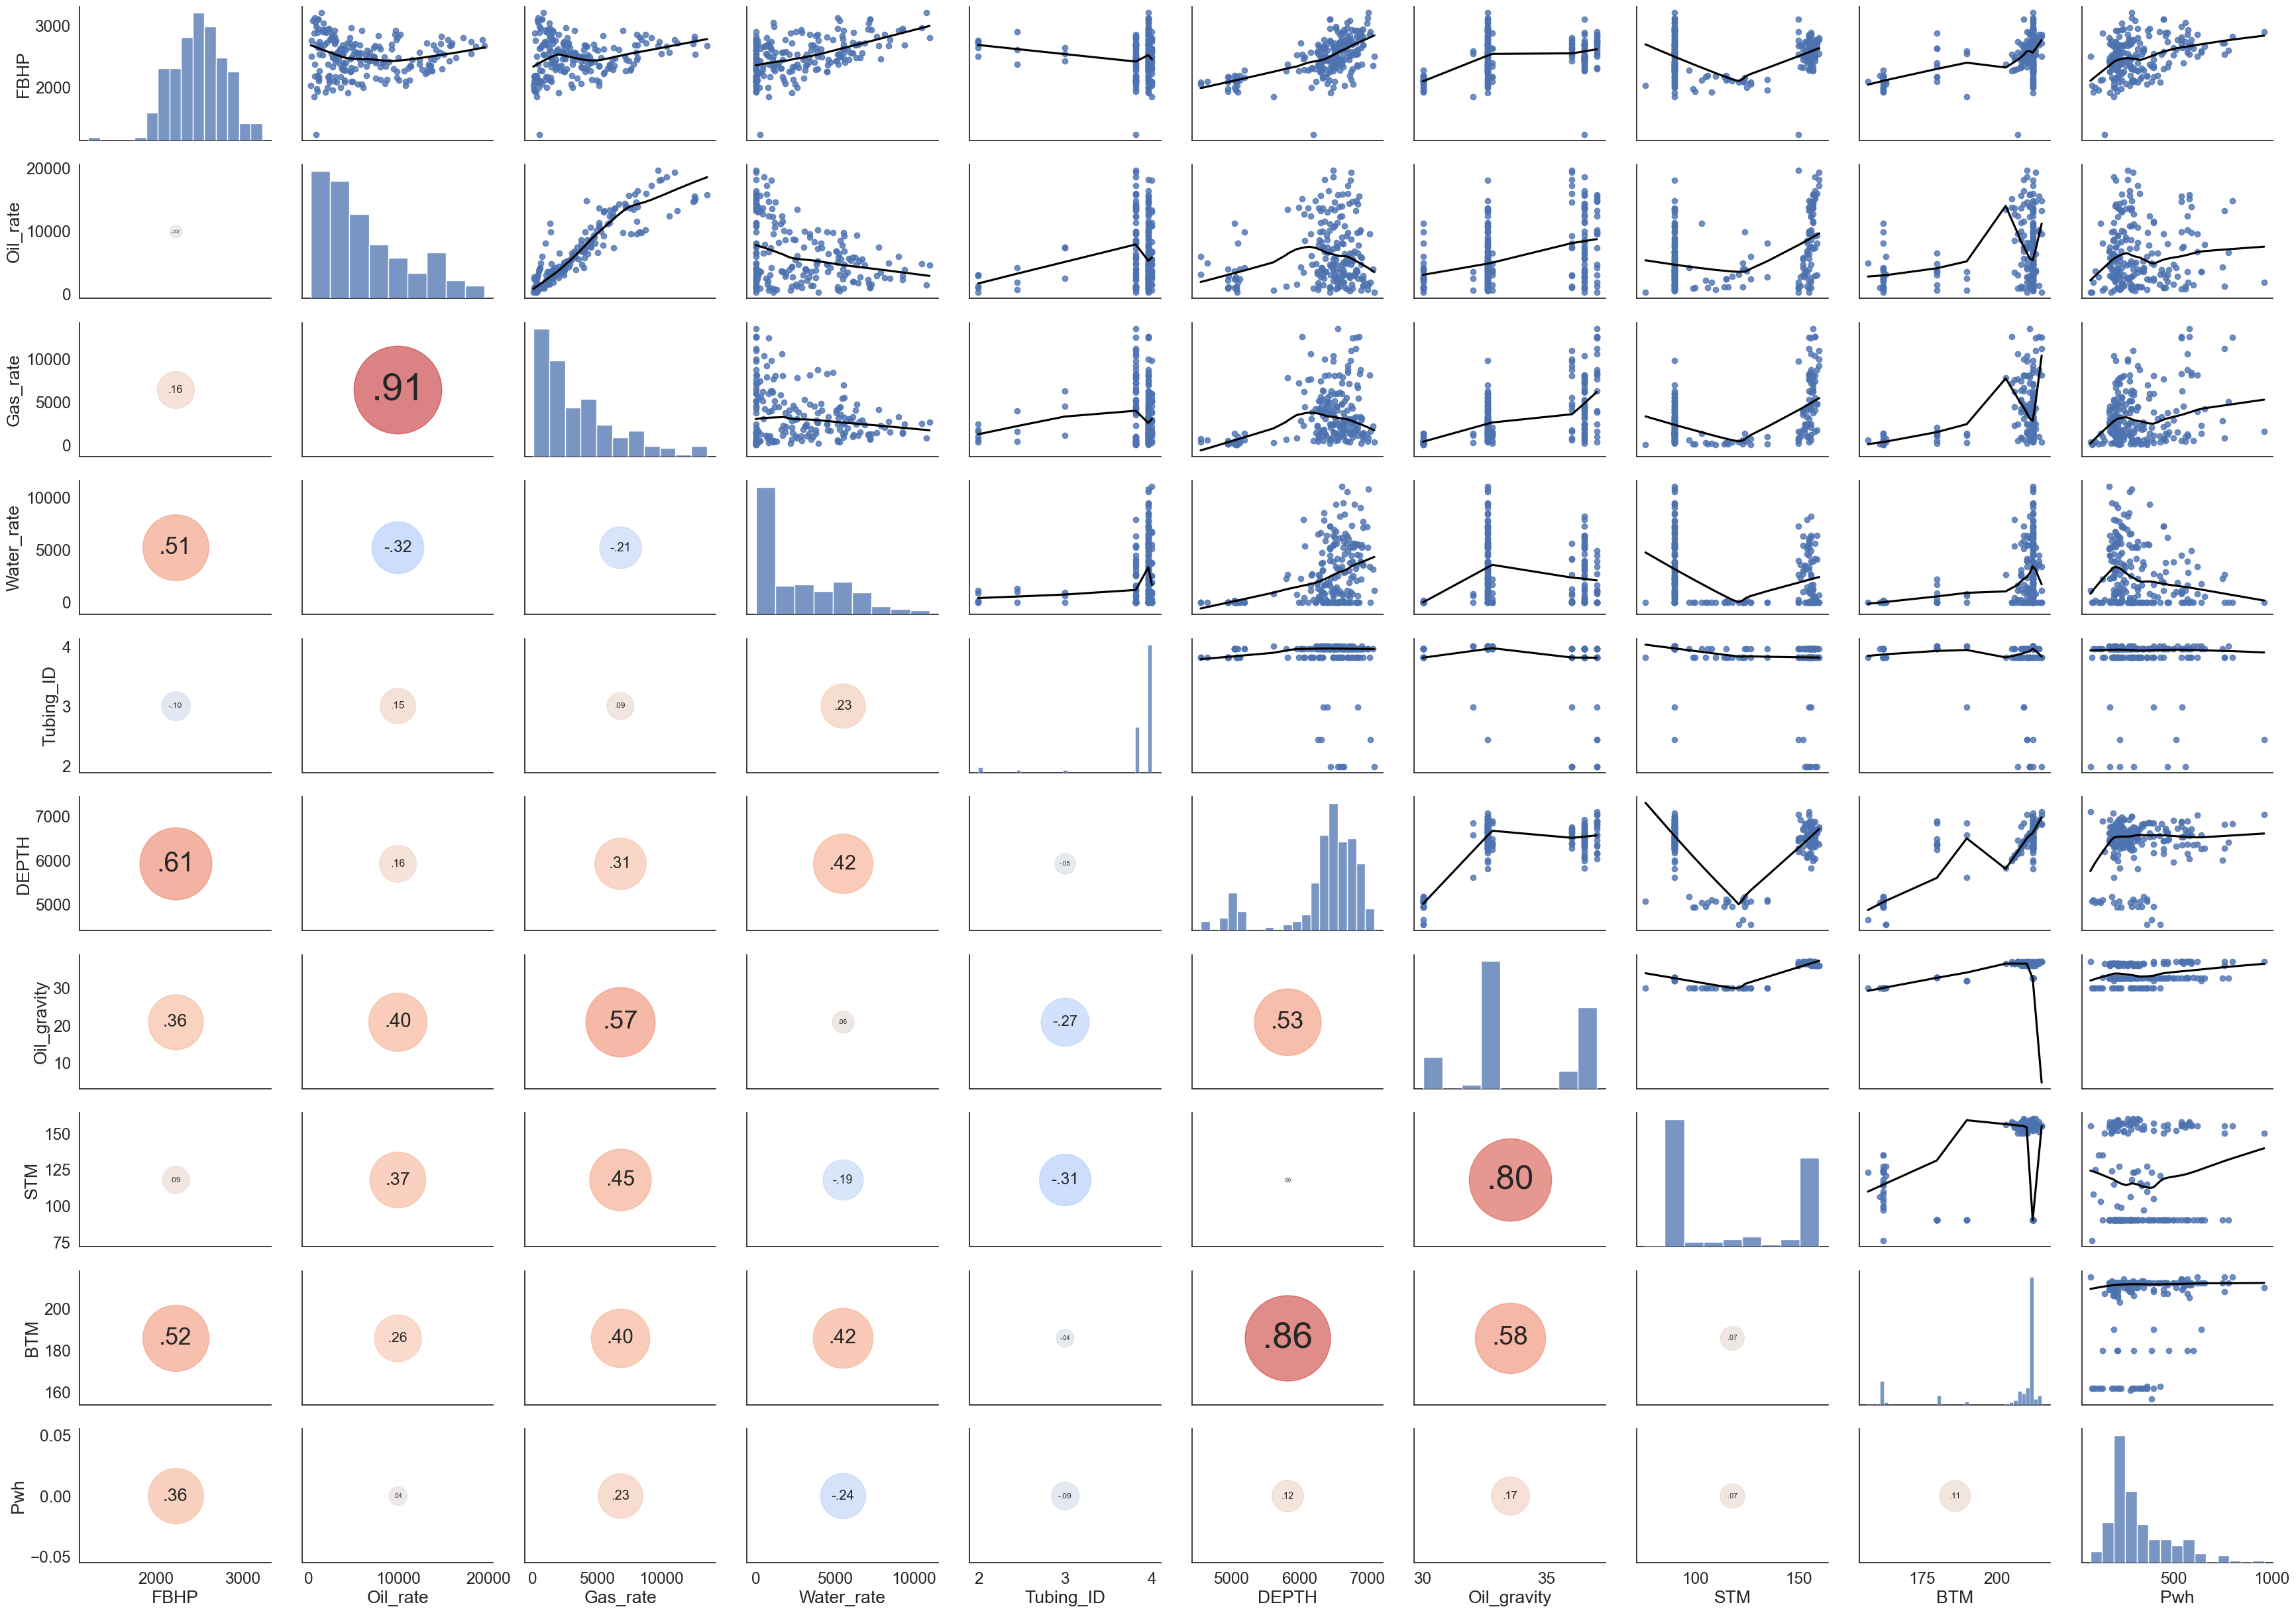

In [29]:
# Examining the scatter plot of paired data
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='white', font_scale=1.6)

g = sns.PairGrid(df, aspect=1.4, diag_sharey=False)

g.map_upper(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.histplot, kde_kws={'color': 'black'})
g.map_lower(corrdot)

# Feature selection

In [612]:
# Avoid adding duplicated dummy variables from Tubing_ID
if sum([col.startswith('Tubing') for col in df.columns]) == 1:
    # create dummy variable for Tubing_ID
    tubing_dummy_vars = pd.get_dummies(df['Tubing_ID'], prefix='Tubing_Id')
    df = pd.concat([df, tubing_dummy_vars], axis=1)
    # remove the last dummy variable
    df = df.drop(['Tubing_Id_4.0'], axis=1)


When building a machine learning model, it is important to split the dataset into training and testing sets before performing any feature engineering or data preprocessing steps. This is to avoid data leakage, which can lead to overly optimistic performance estimates and ultimately result in poor generalization performance of the model on unseen data.

Data leakage occurs when information from the test set is unintentionally included in the training set. This can happen when feature engineering or data preprocessing steps are performed on the entire dataset before splitting it into training and testing sets. In this case, the model may learn information about the test set from the training set, which can result in overly optimistic performance estimates on the test set.

To avoid data leakage, it is recommended to split the dataset into training and testing sets first, and then perform any feature engineering or data preprocessing steps on the training set only. This ensures that the model does not have access to information from the test set during training, and provides a more accurate estimate of the model's generalization performance on unseen data.

Therefore, we will handle the testing set based on the statistics of the training set.

In [635]:
# split data into 80% training and 20% test sets
train_X, test_X, train_y, test_y = train_test_split(df.iloc[:,1:], df.iloc[:,0:1], test_size=0.2, random_state=42)
print(f'Training set: {train_X.shape} shape')
print(f'Test set: {test_X.shape} shape')


Training set: (164, 14) shape
Test set: (42, 14) shape


In [683]:
# Remove outliers based on scatter plot of paaired data and findings from cook-distance after modeling
mask = train_y['FBHP'] < 1500
train_X = train_X.drop(train_X[mask].index)
train_y = train_y.drop(train_y[mask].index)


In [675]:
# Create higher order terms and interaction terms to capture non-linearity in TRAINING SET
# Perform linear transformation (subtraction) and centering predictors to reduce multicollinearity
# c dentoes the variable is centered around the mean
train_X['Oil_rate_c'] =  train_X['Oil_rate'] - train_X['Oil_rate'].mean()
train_X['Gas_rate_c'] = train_X['Gas_rate'] - train_X['Gas_rate'].mean()
train_X['Oil_rate_c_squared'] = train_X['Oil_rate_c']**2
train_X['Gas_rate_c_squared'] = train_X['Gas_rate_c']**2
train_X['DEPTH_c'] = train_X['DEPTH'] -  train_X['DEPTH'].mean()
train_X['DEPTH_c_squared'] = train_X['DEPTH_c']**2
train_X['Pwh_c'] = train_X['Pwh'] -  train_X['Pwh'].mean()
train_X['DEPTH_Pwh'] = train_X['DEPTH'] * train_X['Pwh']
train_X['DEPTH_c_Pwh_c'] = train_X['DEPTH_c'] * train_X['Pwh_c']
train_X['Pwh_squared'] = train_X['Pwh_c']**2
train_X['Oil_c_Gas_c'] = train_X['Oil_rate_c'] * train_X['Gas_rate_c']
train_X['BTM_STM_diff'] = train_X['BTM'] - train_X['STM']


In [676]:
# Create features for the testing set by taking the mean of the corresponding variables in the training set.
# This is because during model serving, we will not have access to the test set statistics.
test_X['Oil_rate_c'] =  test_X['Oil_rate'] - train_X['Oil_rate'].mean()
test_X['Gas_rate_c'] = test_X['Gas_rate'] - train_X['Gas_rate'].mean()
test_X['Oil_rate_c_squared'] = test_X['Oil_rate_c']**2
test_X['Gas_rate_c_squared'] = test_X['Gas_rate_c']**2
test_X['DEPTH_c'] = test_X['DEPTH'] -  train_X['DEPTH'].mean()
test_X['DEPTH_c_squared'] = test_X['DEPTH_c']**2
test_X['Pwh_c'] = test_X['Pwh'] -  train_X['Pwh'].mean()
test_X['DEPTH_Pwh'] = test_X['DEPTH'] * test_X['Pwh']
test_X['DEPTH_c_Pwh_c'] = test_X['DEPTH_c'] * test_X['Pwh_c']
test_X['Pwh_squared'] = test_X['Pwh_c']**2
test_X['Oil_c_Gas_c'] = test_X['Oil_rate_c'] * test_X['Gas_rate_c']
test_X['BTM_STM_diff'] = test_X['BTM'] - test_X['STM']

The mathematical notation for the linear transformation of a predictor variable x:

$x^* = x^{\alpha}$

where $x$ is the original predictor variable, alpha is a scaling parameter, and $x^*$ is the transformed predictor variable.
The following code applies the transformation for various values of alpha ranging from -2 to 2.5 in steps of 0.5.

The logarithmic transformation applied to the predictor variable $x$ is given by:

$x^* = \log(x)$

The main purpose of linearly transforming predictors is to improve their correlation with the target feature (FBHP) in the training dataset.
This is important in linear modeling because higher correlation between predictors and the target feature leads to a more accurate model.
Additionally, transforming predictors can help to overcome certain statistical issues such as non-linearity, non-normality, and heteroscedasticity. 
By applying appropriate transformations, we can improve the distributional properties of the predictor variables and reduce the heteroscedasticity, thereby improving the accuracy and reliability of the model.

In [845]:
df['Tubing_ID'].unique()

array([4.   , 2.441, 3.813, 3.958, 1.995, 2.992])

In [526]:
# Linearly transform predictors
column_names = []
Linear_transformed = []
# Exclude variables with 'Tubing' in their name
col_without_tubing = [col for col in train_X.columns if not col.startswith('Tubing')]
df_without_tubing = train_X[col_without_tubing]
for col in df_without_tubing.corr():
    # Track the transformed variable 
    column_names.append(col)
    for i in np.arange(-2, 2.5, 0.5):
        # Transform the variable in df_without_tubing
        X = df_without_tubing[col]**i
        # compute the correlation
        linear_correlation = X.corr(train_y.squeeze())
        Linear_transformed.append([i, linear_correlation])
    # compute the correlation after logarithmic transformation
    # Check if the column has any negative values
    if any(df_without_tubing[col] < 0):
        # If the column has negative values, skip the transformation
        Linear_transformed.append(['LOG', np.nan])
    else:
        # If the column does not have negative values, apply the transformation
        # add a small number to the variableto avoid divide by zero error
        log_transformed = np.log(df_without_tubing[col]+1e-10)
        linear_correlation_log = log_transformed.corr(train_y.squeeze())
        Linear_transformed.append(["LOG", linear_correlation_log])

# Create a df for the correation of the transformed predictor and the correspodning scaling parameter
Linear_transformed = pd.DataFrame(Linear_transformed, columns=["Transformation", "Correlation"])
# # Calculates the length of the list generated by scaling for each variable and adds 1 to account for
# #  the logarithmic transformation that was also performed.
LinearTransform["Variable"] = np.repeat(column_names, len(np.arange(-2, 2.5, 0.5)) + 1)

# Group the data by column 'B'
grouped = LinearTransform.groupby('Variable')

# Apply the idxmax function to each group
max_index = grouped['Correlation'].idxmax()

# Extract the rows corresponding to the max value in each group
result = LinearTransform.loc[max_index]

#merge the perason correlation before and after transformation
train = pd.concat([df_without_tubing, train_y], axis=1).corr().iloc[-1]
result = result.merge(train, left_on='Variable', right_index=True)
# rename the columns according to the specified transformations
result = result.rename(columns={
    'Transformation': 'Transformation_type',
    'Correlation': 'After_transformation',
    'FBHP': 'Before_transformation'
})

# Reorder the columns according to the specified order
result = result.reindex(columns=['Variable', 'Before_transformation', 'After_transformation', 'Transformation_type'])
print('The linear correlation (Pearson) of predictors with Target feature (FBHP) before and after transformation')
result

The linear correlation (Pearson) of predictors with Target feature (FBHP) before and after transformation


,Variable,Before_transformation,After_transformation,Transformation_type
69,BTM,0.518779,0.519488,LOG
199,BTM_STM_diff,0.122401,0.154038,LOG
38,DEPTH,0.613665,0.617939,2.0
159,DEPTH_Pwh,0.437556,0.480451,LOG
126,DEPTH_c,0.613665,0.613665,1.0
161,DEPTH_c_Pwh_c,-0.143644,0.118294,-1.5
133,DEPTH_c_squared,-0.443566,0.024593,-0.5
19,Gas_rate,0.152663,0.219178,LOG
97,Gas_rate_c,0.152663,0.499815,1.5
116,Gas_rate_c_squared,0.173442,0.173622,1.0


In [684]:
# Normalize the training and test data
scaler = MinMaxScaler()
scaled_train_X= scaler.fit_transform(train_X)
scaled_test_X= scaler.transform(test_X)
scaled_train_X = pd.DataFrame(scaled_train_X, columns = train_X.columns) 
scaled_test_X = pd.DataFrame(scaled_test_X, columns = test_X.columns)
print(f'Training set: {scaled_train_X.shape} shape')
print(f'Test set: {scaled_test_X.shape} shape')

Training set: (163, 26) shape
Test set: (42, 26) shape


In [ ]:
def reduce_vif(X,  threshold=10)
    '''
    Returns a dataframe of predictor combinations with VIF values below a given threshold
    
    Parameters
    ----------
    X : pandas dataframe
        dataframe containing all the predictors to be considered
    threshold : float
        vif threshold value

    Return
    ---------
    best combination of predictors that have VIF less than the user-defined threshold
     along with the corresponding adjusted r-squared
    '''
    result = []
    # Loop through all possible combinations of predictors
    for n in range(2, len(X.columns)):
        for combination in combinations(X.columns, n):
            # Calculate VIF for the predictors in the current combination
            x = X[list(combination)]
            vif = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
            # If the maximum VIF is below the threshold, add the combination to the result list
            if max(vif) < threshold:
                result.append((max(vif), str(list(combination))))
    # Return the result list as a dataframe
    return pd.DataFrame(result, columns=['VIF', 'combinations'])

def fit_model(combination, X, y):
        """Fit a linear model on the optimal predictor obtained with reduce_vif()"""
    # Add a constant to the predictors for the intercept term
    predictors = sm.add_constant(X[combination])
    # Fit the MLR model
    model = sm.OLS(y.values, predictors).fit()
    adj_rsquared = model.rsquared_adj

    # Initialize the max_adj_rsquared and best_combination variables
    max_adj_rsquared = -inf
    best_combination = None

    # If the current combination has a higher R-squared than the previous best, update the max R-squared and best combination       
    if adj_rsquared > max_adj_rsquared:
        max_adj_rsquared = adj_rsquared
        best_combination = combination
    return best_combination, max_adj_rsquared

X = train_X
y = train_y
# Reduce the predictors to only those with VIF values below the threshold
results_VIF = reduce_vif(X, threshold=10.0)
# Convert the combinations in the result_VIF dataframe from tuples to lists
result_VIF = [ast.literal_eval(item) for item in results_VIF['combinations']]
# Fit MLR models for each combination of predictors and store the best combination and max R-squared for each
best_combinations = [fit_model(com, X, y) for com in result_VIF]
# Convert the list of best combinations and max R-squareds to a dataframe
best_combinations_rsq = pd.DataFrame(best_combinations, columns=['best_combinations', 'adj_rsquared'])
# calculate the number of variables for each combination 
best_combinations_rsq['combination_count'] = best_combinations_rsq['best_combinations'].apply(len)
best_combinations_rsq.sort_values("adj_rsquared", ascending = False)

/usr/local/lib/python3.8/dist-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,best_combinations,adj_rsquared,combination_count
29479,"[Water_rate, DEPTH, Pwh, Oil_rate**2, Gas_rate...",0.749659,7
39335,"[Water_rate, DEPTH, Pwh, Oil_rate**2, Gas_rate...",0.748750,8
39337,"[Water_rate, DEPTH, Pwh, Oil_rate**2, Gas_rate...",0.748099,8
17382,"[Water_rate, DEPTH, Pwh, Gas_rate_C, Oil_rate*...",0.748029,6
14559,"[Gas_rate, Water_rate, DEPTH, Pwh, Oil_rate**2...",0.748029,6
...,...,...,...
1343,"[Oil_rate, Tubing_ID, Tubing_Id_2.441, Tubing_...",-0.011901,4
135,"[Oil_rate_C, Tubing_Id_2.992]",-0.012388,2
13,"[Oil_rate, Tubing_Id_2.992]",-0.012388,2
295,"[Oil_rate, Tubing_Id_2.441, Tubing_Id_2.992]",-0.014136,3


In [678]:
# extract the independent variables
X = scaled_train_X[[
'Oil_rate_c_squared', 'DEPTH','Water_rate','Tubing_Id_1.995', 'Pwh'
]]

# calculate the VIF for each variable
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,variables,VIF
0,Oil_rate_c_squared,1.912037
1,DEPTH,8.911299
2,Water_rate,3.445399
3,Tubing_Id_1.995,1.079677
4,Pwh,3.500637


# Modeling

In [720]:
#fit a MLR model
predictors = sm.add_constant(scaled_train_X[['Oil_rate_c_squared', 'DEPTH','Water_rate','Tubing_Id_1.995', 'Pwh']])
# reset the index
reindexed_train_y = train_y.reset_index(drop=True)
# Fit the MLR model
model = sm.OLS(reindexed_train_y, predictors).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   FBHP   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     108.7
Date:                Sun, 16 Apr 2023   Prob (F-statistic):           3.86e-49
Time:                        10:31:12   Log-Likelihood:                -1033.5
No. Observations:                 163   AIC:                             2079.
Df Residuals:                     157   BIC:                             2097.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1764.7235     40

# Diagnostic tests

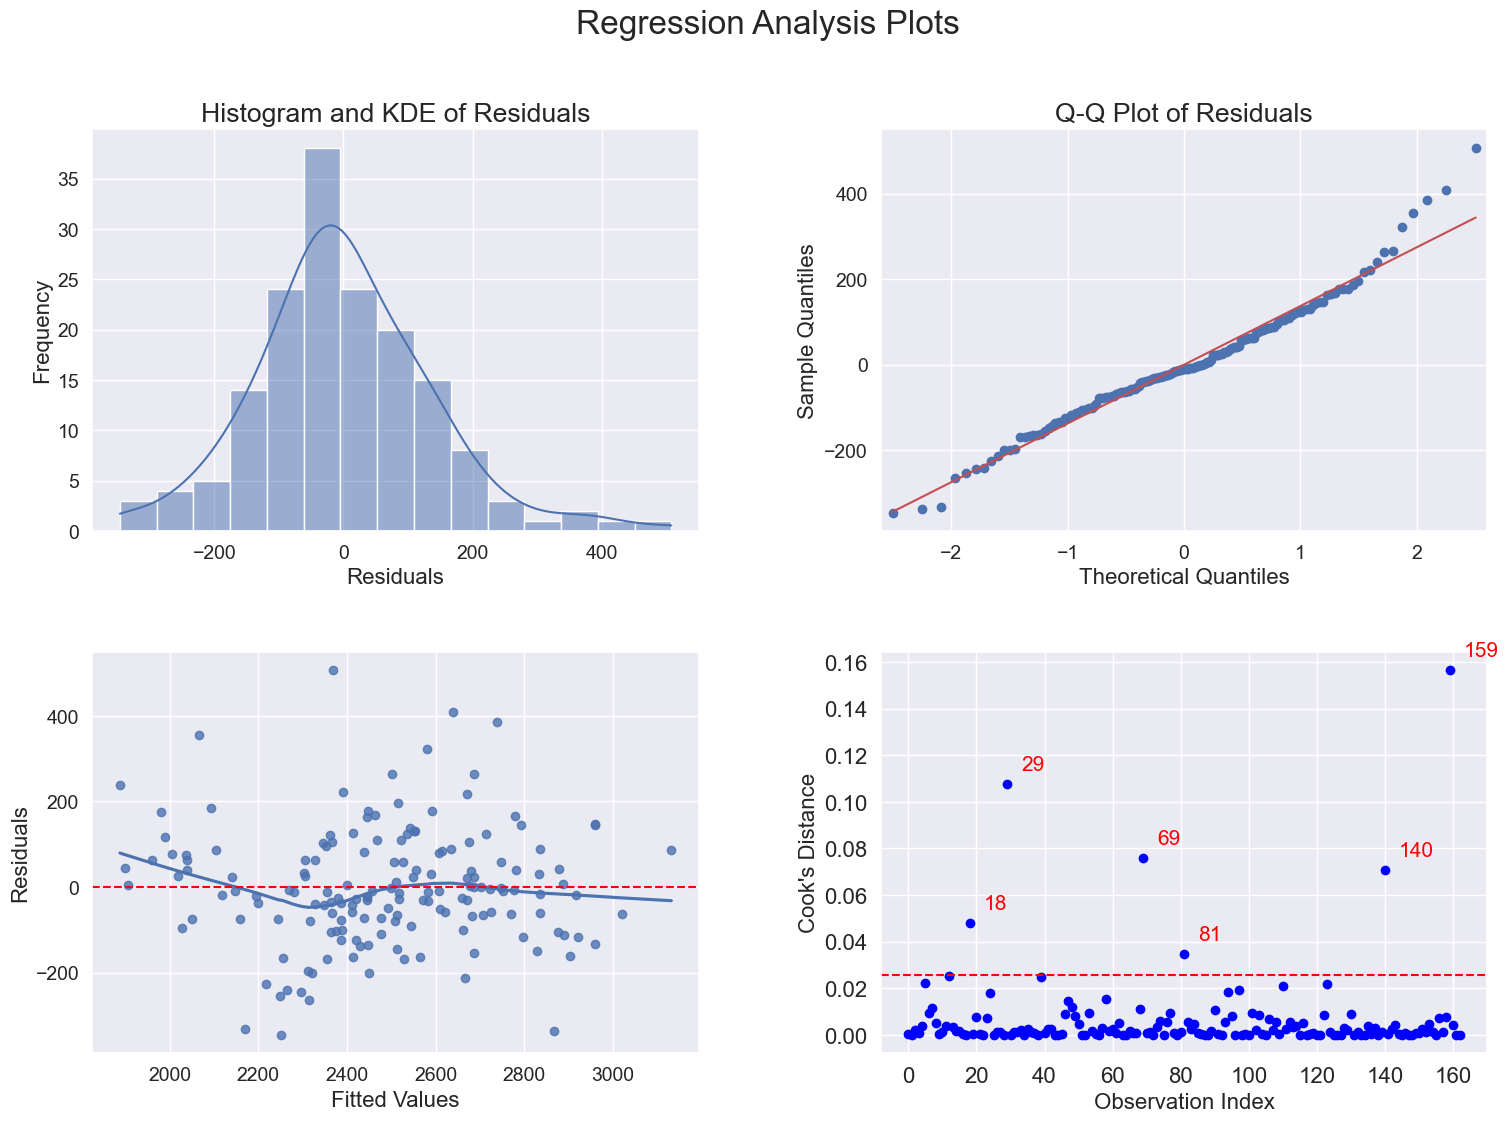

In [721]:
exog = model.model.exog
resid = model.resid

# Set the style of the plot
sns.set_style('darkgrid')

# Create a figure with two subplots, arranged in a 2x2 grid
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))

# Plot the histogram and KDE on the first subplot
sns.histplot(resid, kde=True, ax=ax1)
ax1.set_title('Histogram and KDE of Residuals')

# Set the font size for the axes labels and ticks for the first subplot
ax1.tick_params(labelsize=14)
ax1.set_xlabel('Residuals', fontsize=16)
ax1.set_ylabel('Frequency', fontsize=16)



# Generate the Q-Q plot on the second subplot
sm.qqplot(resid, line='s', ax=ax2)
ax2.set_title('Q-Q Plot of Residuals')

# Set the font size for the axes labels and ticks for the third subplot
ax2.tick_params(labelsize=14)
ax2.set_xlabel('Theoretical Quantiles', fontsize=16)
ax2.set_ylabel('Sample Quantiles', fontsize=16)


# Plot the residual plot on the third subplot
# sns.regplot(x=model.fittedvalues, y=resid, lowess=True, scatter_kws={"color": "blue", "alpha": 0.3, "s": 100})
sns.regplot(x=model.fittedvalues, y=resid, lowess=True, ax=ax3)
# Add horizontal lines at y=300 and y=-300 on the second subplot
# ax3.axhline(y=300, color='red', linestyle='--')
ax3.axhline(y=-0, color='red', linestyle='--')

# Increase font size of x and y labels and ticks for the second subplot
ax3.set_xlabel('Fitted Values', fontsize=16)
ax3.set_ylabel('Residuals', fontsize=16)
ax3.tick_params(labelsize=14)


# Calculate Cook's distance
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

# Observations that have a Cook-distance value that is 4 times larger than the mean value of
# Cook-distance will be classified as influential observations
threshold = cooks_d.mean() * 4
influential_points = np.where(cooks_d > threshold)[0]

# Create the Cook's distance plot on the fourth subplot
ax4.scatter(range(len(exog)), cooks_d, color='blue')

# Add a horizontal line showing the threshold
ax4.axhline(y=threshold, color='red', linestyle='--')

# Label the influential points on the Cook's distance plot
for i in influential_points:
    ax4.annotate(str(i), (i, cooks_d[i]), xytext=(10, 10), textcoords='offset points', fontsize=15, color='red')

# Set the font size for the axes labels and ticks for the fourth subplot
ax4.tick_params(labelsize=14)
ax4.set_xlabel('Observation Index', fontsize=16)
ax4.set_ylabel("Cook's Distance", fontsize=16)

# Add labels and title to the plot
fig.suptitle('Regression Analysis Plots', fontsize=24)

# Set the font size of the tick labels
plt.tick_params(labelsize=16)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Show the plot
plt.show()


In [688]:
# Inverse the transform of the scaled data back to the original values
inversed_train_X = pd.DataFrame(scaler.inverse_transform(scaled_train_X), columns = train_X.columns)
inversed_train_X = inversed_train_X[[
        'Oil_rate_c_squared', 
        'Water_rate', 
        'DEPTH',
        'Water_rate',
        'Tubing_Id_1.995', 
        'Pwh'
]]
inversed_train_X.iloc[influential_points]

,Oil_rate_c_squared,Water_rate,DEPTH,Water_rate,Tubing_Id_1.995,Pwh
18,1.649207e+06,0.0,6406.0,0.0,0.0,180.0
29,2.502786e+07,0.0,6597.0,0.0,1.0,560.0
69,3.131281e+07,2200.0,6901.0,2200.0,0.0,140.0
81,2.931990e+07,1131.0,6700.0,1131.0,0.0,560.0
140,2.440148e+07,2634.0,6285.0,2634.0,0.0,760.0
159,1.052214e+07,130.0,6630.0,130.0,1.0,180.0


# Evaluation

In [724]:
# Calculate predicted values for training set 
constant = pd.Series(np.ones((train_X.shape[0],)), name='constant')
train_predictors = pd.concat([constant, 
    scaled_train_X[['Oil_rate_c_squared', 'DEPTH','Water_rate','Tubing_Id_1.995', 'Pwh']].reset_index(drop=True)], axis=1)

train_pred_y = model.predict(train_predictors)
r_squared_train = r2_score(train_y, train_pred_y)
# Calculate RMSE value 
rmse_train = np.sqrt(mean_squared_error(train_y, train_pred_y))
# # Calculate r-square value 
print(f"Traning R-Squared: {r_squared_train:.2f}")
print(f"Training RMSE: {rmse_train:.2f}")

Traning R-Squared: 0.78
Training RMSE: 137.18


In [728]:
# Calculate predicted values for testing set 
constant = pd.Series(np.ones((test_X.shape[0],)))
test_predictors = pd.concat([constant,
    scaled_test_X[['Oil_rate_c_squared', 'DEPTH','Water_rate','Tubing_Id_1.995', 'Pwh']].reset_index(drop=True)], axis=1)

test_pred_y = model.predict(test_predictors)
r_squared_test = r2_score(test_y, test_pred_y)
# Calculate RMSE value 
rmse_test = np.sqrt(mean_squared_error(test_y, test_pred_y))
# # Calculate r-square value 
print(f"Testing R-Squared: {r_squared_test:.2f}")
print(f"Testing RMSE: {rmse_test:.2f}")

Testing R-Squared: 0.78
Testing RMSE: 132.78


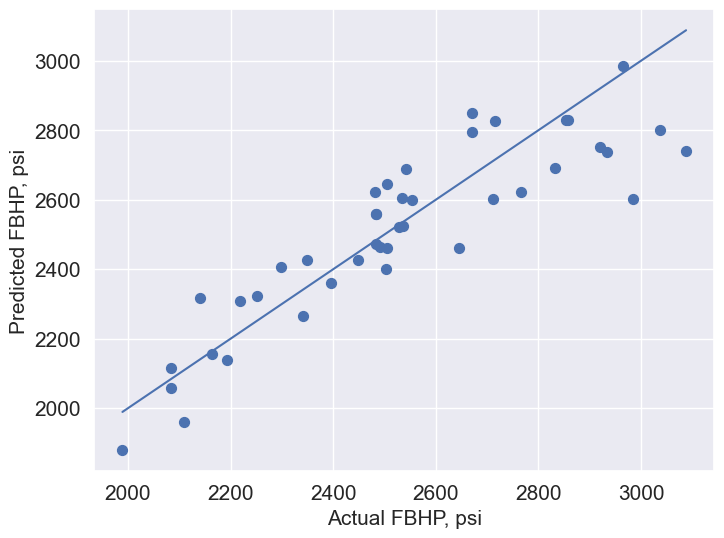

In [729]:
# cross plot
fig, ax = plt.subplots(1, 1, figsize=(8,6))
# Create a scatter plot
ax.scatter(test_y, test_pred_y, marker='o', s=50, c='b', alpha=1)

# Add a 45-degree line
ax.plot([np.min(test_y),np.max(test_y)], [np.min(test_y),np.max(test_y)], linestyle='-')

# Add labels and a title
plt.xlabel("Actual FBHP, psi", fontsize=15)
plt.ylabel("Predicted FBHP, psi",  fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# plt.savefig("cross plot.png", dpi=1600, bbox_inches='tight')
# Show the plot
plt.show()

In [768]:
# We cannot use the original scaler for preprocessing the data during production,
# since the model only needs 5 features. Therefore, we need to instantiate another scaler
# to preprocess the new number of features that were useful for the linear model.
scaler_5 = MinMaxScaler()
# Fit the new scaler on your training data with only 5 features
# fit_transform() method will fit the scaler and transform the data in one step
# and return the transformed data, which we can store in 'X_new_5_scaled'
X_new_5_scaled = scaler_5.fit_transform(train_X[['Oil_rate_c_squared', 'DEPTH', 'Water_rate', 'Tubing_Id_1.995', 'Pwh']])


# Save models

In [847]:
# Save the scaler
with open('scaler_5.pickle', 'wb') as f:
    pickle.dump(scaler_5, f)

In [848]:
# Save the model
with open('lr_model.pickle', 'wb') as f:
    pickle.dump(model, f)

# Test the saved objects

In [791]:
# Load the scaler
with open('scaler_5.pickle', 'rb') as f:
    loaded_scaler = pickle.load(f)

In [754]:
# Load the model
with open('model.pickle', 'rb') as f:
    loaded_model = pickle.load(f)

This code demonstrates how to preprocess input data and make predictions using a pre-trained machine learning model in a Flask web application. The main purpose of this code is to show how to perform preprocessing on input data in the same way it was done during training and evaluation, and then compare the output of the model during the development phase with the test output during production. This comparison helps ensure that the model is performing as expected and that the preprocessing is consistent across all stages of the machine learning pipeline.

In [843]:
# Define input values as a dictionary
input_values = {'Oil_rate': 4957, 'depth': 6659, 'water_rate': 8400, 'tubing_id_1_9992': 'No', 'pwh': 250}

# Convert categorical feature 'tubing_id_1_9992' to binary format
tubing_id_1_9992_binary = 1 if input_values['tubing_id_1_9992'] == 'Yes' else 0

# Center and square input oil rate using training mean
training_oil_mean = 6195.78527607362
centered_squared_oil_rate = (input_values['Oil_rate'] - training_oil_mean) ** 2

# Create a numpy array with the input values (excluding the categorical feature)
input_arr = np.array([centered_squared_oil_rate, input_values['depth'], input_values['water_rate'], tubing_id_1_9992_binary, input_values['pwh']])

# Reshape the array to have one row and the same number of columns as the training data
input_arr = input_arr.reshape(1, -1)

# Remove feature names from the scaler
loaded_scaler.feature_names_in_ = None

# Scale the input using the loaded scaler
scaled_input = loaded_scaler.transform(input_arr)

# Create a constant array with the same number of rows as the scaled input array
constant = np.ones((scaled_input.shape[0], 1))

# Predict the output for the scaled input using the trained model
output = model.predict(np.hstack((constant, scaled_input)))

# Create a test input array with the same number of features as the training data
test_input = np.hstack((1, scaled_test_X.iloc[0][['Oil_rate_c_squared', 'DEPTH', 'Water_rate', 'Tubing_Id_1.995', 'Pwh']].values))

# Predict the output for the test input using the trained model
test_output = model.predict(test_input)

# Ensure that the predicted output matches the test output
assert output == test_output
